<a href="https://colab.research.google.com/github/jacobdwatters/NIOSH-Project/blob/main/SIG_SUB_Regression_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

import scipy as sp
from scipy import stats

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [32]:
FEATURES = ['VIOLATION_OCCUR_DT', 'MINE_ID', 'MINE_TYPE', 'COAL_METAL_IND', 'SIG_SUB', 'LIKELIHOOD', 
            'INJ_ILLNESS', 'NO_AFFECTED', 'NEGLIGENCE', 'VIOLATOR_VIOLATION_CNT',
            'VIOLATOR_INSPECTION_DAY_CNT']
TARGETS = ['PROPOSED_PENALTY']

In [33]:
path = '/content/gdrive/My Drive/NIOSH Project/data/violations_processed_after_2010.csv'
violation_data = pd.read_csv(path)

print('Samples in dataset: ', len(violation_data))

Samples in dataset:  1429135


In [34]:
significant_data = violation_data[violation_data['SIG_SUB'] == 'Y']
print('Significant and substantial samples in dataset: ', len(significant_data))

Significant and substantial samples in dataset:  342474


## Prepare and Split Significant Data

In [35]:
FEATURES = ['MINE_TYPE', 'COAL_METAL_IND', 'LIKELIHOOD', 
            'INJ_ILLNESS', 'NO_AFFECTED', 'NEGLIGENCE', 'VIOLATOR_VIOLATION_CNT',
            'VIOLATOR_INSPECTION_DAY_CNT']
TARGETS = ['PROPOSED_PENALTY']

X = significant_data[FEATURES]
y = significant_data[TARGETS]

# Define which columns should be encoded vs scaled
columns_to_encode = ['MINE_TYPE', 'COAL_METAL_IND', 'LIKELIHOOD', 'INJ_ILLNESS', 'NEGLIGENCE']
columns_to_scale  = ['VIOLATOR_VIOLATION_CNT', 'NO_AFFECTED', 'VIOLATOR_INSPECTION_DAY_CNT']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns  = scaler.fit_transform(X[columns_to_scale])
encoded_columns = ohe.fit_transform(X[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
X_pre = np.concatenate([scaled_columns, encoded_columns], axis=1)
np.nan_to_num(X_pre, copy=False)

print('Features shape:', X_pre.shape)

X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size = 0.25, random_state = 0)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_train shape:', y_test.shape)

Features shape: (342474, 22)
X_train shape: (256855, 22)
X_test shape: (85619, 22)
y_train shape: (256855, 1)
y_train shape: (85619, 1)


## Train Desicion Tree

In [36]:
tree_regressor_adaboost = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=12), n_estimators=5, random_state=0
)
tree_regressor_adaboost.fit(X_train, np.ravel(y_train))

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=12),
                  n_estimators=5, random_state=0)

In [37]:
tree_regressor_adaboost_y_pred_train = tree_regressor_adaboost.predict(X_train)
tree_regressor_adaboost_y_pred_test = tree_regressor_adaboost.predict(X_test)

tree_regressor_adaboost_r_squared_train = r2_score(y_train, tree_regressor_adaboost_y_pred_train)
tree_regressor_adaboost_r_squared_test = r2_score(y_test, tree_regressor_adaboost_y_pred_test)

tree_regressor_adaboost_mae_train = mean_absolute_error(y_train, tree_regressor_adaboost_y_pred_train)
tree_regressor_adaboost_mae_test = mean_absolute_error(y_test, tree_regressor_adaboost_y_pred_test)

print('Decision Tree Regression with AdaBoost Scores:')
print('Training R^2 = %.3f' % tree_regressor_adaboost_r_squared_train)
print('Training MAE = %.3f' % tree_regressor_adaboost_mae_train)

print('\nTesting R^2 = %.3f' % tree_regressor_adaboost_r_squared_test)
print('Testing MAE = %.3f' % tree_regressor_adaboost_mae_test)

Decision Tree Regression with AdaBoost Scores:
Training R^2 = 0.751
Training MAE = 1055.381

Testing R^2 = 0.539
Testing MAE = 1207.748


## Train Neural Network

In [40]:
def scheduler(epoch, lr):
  if epoch < 85:
    return lr
  else: # Drop learning rate after the first 85 epochs
    return lr*np.exp(-0.05)

In [45]:
batch_size = 4096*2
epochs = 45
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model = keras.Sequential()

model.add(keras.Input(shape = (len(X_train[0]), ) ))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(1, activation="linear"))


opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=opt)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    callbacks=[callback], validation_data=(X_test, y_test))

Epoch 1/45
32/32 [==============================] - 2s 22ms/step - loss: 45438908.0000 - val_loss: 42435212.0000 - lr: 0.0100
Epoch 2/45
32/32 [==============================] - 1s 17ms/step - loss: 37299012.0000 - val_loss: 34265096.0000 - lr: 0.0100
Epoch 3/45
32/32 [==============================] - 1s 17ms/step - loss: 30417670.0000 - val_loss: 28056974.0000 - lr: 0.0100
Epoch 4/45
32/32 [==============================] - 1s 17ms/step - loss: 25566798.0000 - val_loss: 23930680.0000 - lr: 0.0100
Epoch 5/45
32/32 [==============================] - 0s 15ms/step - loss: 23201484.0000 - val_loss: 22519200.0000 - lr: 0.0100
Epoch 6/45
32/32 [==============================] - 1s 16ms/step - loss: 22704126.0000 - val_loss: 22425312.0000 - lr: 0.0100
Epoch 7/45
32/32 [==============================] - 1s 16ms/step - loss: 22359282.0000 - val_loss: 21875184.0000 - lr: 0.0100
Epoch 8/45
32/32 [==============================] - 1s 17ms/step - loss: 21743054.0000 - val_loss: 21035208.0000 - lr:

In [46]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print('r2 = %.3f' % r2)

2676/2676 [==============================] - 4s 1ms/step
r2 = 0.586


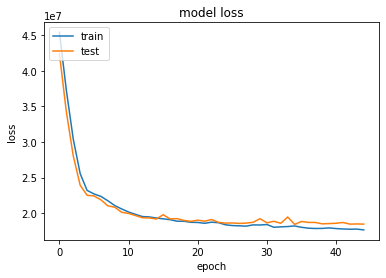

In [47]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()